In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from ipywidgets import *
import pickle
from Classes import *
from Functions import *


def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)   
def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
n = 50
m = 1
s = 1
M  = np.array(n*[np.linspace(0 ,  m, n)])
S = np.array(n*[np.linspace(s,0.001, n)]).T

# ABM in exemplary Networks

In [3]:
class ABM(object):
    def __init__(self,net, par,  phi1 = "in", phi2 = "out",alpha = 1):
        mu1, sig1, mu2, sig2 = par
        self.N = net.number_of_nodes()
        self.alpha = alpha
        if phi1 == "in":
            self.phi1 = self.phi1_in
        if phi1 == "out":
            self.phi1 = self.phi1_out
        if phi1 == "red":
            self.phi1 = self.phi1_red
        if phi2 == "in":
            self.phi2 = self.phi2_in
        if phi2 == "out":
            self.phi2 = self.phi2_out
        if phi2 == "red":
            self.phi2 = self.phi2_red
        self.theta1  = np.random.normal(mu1,sig1,self.N)
        self.theta2 = np.random.normal(mu2,sig2,self.N)
        self.s = np.array(self.N*[0])
        self.s_old = np.array(self.N*[-1])
        self.net = net
        self.neighbors =  [list(self.net.neighbors(node)) for node in net ]
        self.X = []
        self.state_=[self.s]
        self.layout = nx.spring_layout(self.net)
            
    def plot_evolution(self):
        for i in range(len(self.state_)):
            fig = plt.figure(figsize= (5,5))
            ax= fig.add_subplot(111)
            n_col = ["r" if i == 1 else "lightblue" for i in self.state_[i]]
            #e_col_1 = ["m" if (u in active1_i and v in active1_i) else "r" for (u, v) in self.net1.edges()]
            labels = {i:np.round(t1,2) for i,t1 in enumerate(self.theta1)}
            phi1 = self.phi1(self.state_[i])
            phi2 = self.phi2(self.state_[i])
            labels = {}
            for i in range(self.N):
                labels[i]=np.round((self.theta1[i], self.theta2[i], phi1[i], phi2[i]),2)
            net = nx.draw_networkx(self.net, pos= self.layout, ax= ax, node_color= n_col, with_labels = True)
            pos_higher = {}
            for k, v in self.layout.items():
                if(v[1]>0):
                    pos_higher[k] = (v[0], v[1]+0.1)
                else:
                    pos_higher[k] = (v[0], v[1]-0.1)
            ax.set_xlim([2*x for x in ax.get_xlim()])
            ax.set_ylim([2*y for y in ax.get_ylim()])
            fig.show()
        return
    
    def new_layout(self):
        self.layout = nx.spring_layout(self.net)
        
    def step(self, run_num):
        for run in range(run_num):
            s_new = self.s.copy()
            failed = list(np.where(self.s == 1)[0])
            healthy = list(np.where(self.s == 0)[0])
            s_new[healthy] = [self.phi1()[healthy] > self.theta1[healthy]]
            s_new[failed]  = [self.phi2()[failed]  < self.theta2[failed]]
            
            if np.array_equal(s_new, self.s) or np.array_equal(s_new, self.s_old): #converged or cyclic
                self.s_old = self.s
                self.s = s_new
                self.X.append(np.mean(self.s))
                self.state_.append(self.s)
                break
                
            self.s_old = self.s
            self.s = s_new
            self.X.append(np.mean(self.s))
            self.state_.append(self.s)
    def phi1_in(self, s = None):
        if s is None:
            s = self.s
        loc  = np.array([  np.mean(s[neigh]) for neigh  in self.neighbors]) 
        glob =   np.mean(s)
        return self.alpha*loc + (1-self.alpha)*glob
    def phi2_in(self,  s = None):
        if s is None:
            s = self.s
        loc  = np.array([1-np.mean(s[neigh]) for neigh  in self.neighbors]) 
        glob = 1-np.mean(s)
        return self.alpha*loc + (1-self.alpha)*glob
    def phi1_out(self, s = None):
        if s is None:
            s = self.s
        load = np.array([    s[i]/len(neigh) for i,neigh in enumerate(self.neighbors)])
        loc  = np.array([np.sum(load[neigh]) for neigh in self.neighbors])
        glob =   np.mean(s)
        return self.alpha*loc + (1-self.alpha)*glob
    def phi2_out(self, s = None):
        if s is None:
            s = self.s
        load = np.array([(1-s[i])/len(neigh) for i,neigh in enumerate(self.neighbors)])
        loc  = np.array([np.sum(load[neigh]) for neigh in self.neighbors])
        glob = 1-np.mean(s)
        return self.alpha*loc + (1-self.alpha)*glob
    def phi1_sup(self, s = None):
        if s is None:
            s = self.s
        seek = np.array([(s[i])/(len(neigh)-np.sum(s[neigh])) for i,neigh in enumerate(self.neighbors)])
        loc  = np.array([np.sum(seek[neigh]) for neigh in self.neighbors])
        glob = np.sum(s)/(self.N-sum(s))
        return self.alpha*loc + (1-self.alpha)*glob
    def phi2_sup(self, s = None):
        if s is None:
            s = self.s
        supp = np.array([(1-s[i])/np.sum(s[neigh]) for i,neigh in enumerate(self.neighbors)])
        loc  = np.array([np.sum(supp[neigh]) for neigh in self.neighbors])
        glob = (self.N-sum(s))/ np.sum(s)
        return self.alpha*loc + (1-self.alpha)*glob


In [4]:
net1 = nx.star_graph(5)
net2 = nx.star_graph(2)
mapping = {0: 6, 1: 7, 2: 8}
net2 = nx.relabel_nodes(net2, mapping)



C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


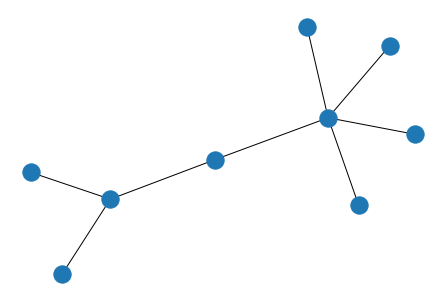

In [5]:
net = nx.compose(net1,net2)
net.add_edge(5,6)
nx.draw(net)

In [6]:
abm = ABM(net, (0.3,0.6,0.5,0.6))
abm.theta1 = np.array([-0.15,0.55,1.1, 0.9,0.05, 0.15, -0.65,1.3, 0.95] )
abm.theta2 = np.array([-0.6, 0.1, 2.5,  0.25, -0.3, 0.25,0.75,1.4, 1])
abm.step(20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


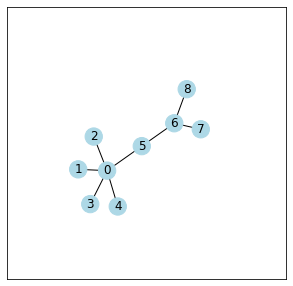

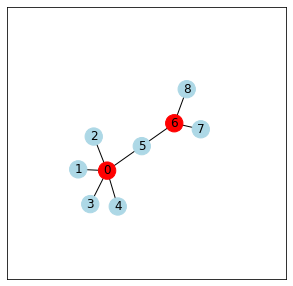

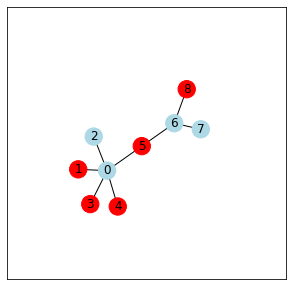

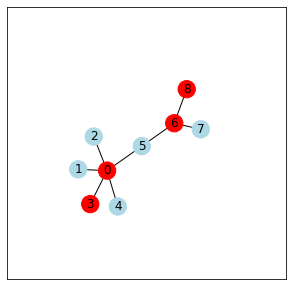

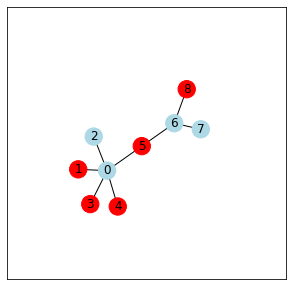

In [7]:
abm.new_layout()
abm.plot_evolution()

In [ ]:
{0: ([-0.15, -0.6 ,  0.  ,  4.5 ]), 1: ([0.55, 0.3 , 0.  , 0.2 ]), 2: ([1.1, 2.5, 0. , 0.2]), 3: ([0.9 , 0.25, 0.  , 0.2 ]), 4: ([ 0.05, -0.3 ,  0.  ,  0.2 ]), 5: ([0.15, 0.25, 0.  , 0.53]), 6: ([-0.65,  0.75,  0.  ,  2.5 ]), 7: ([1.3 , 1.4 , 0.  , 0.33]), 8: ([0.95, 1.  , 0.  , 0.33])}
{0: ([-0.15, -0.6 ,  0.  ,  4.5 ]), 1: ([0.55, 0.3 , 1.  , 0.  ]), 2: ([1.1, 2.5, 1. , 0. ]), 3: ([0.9 , 0.25, 1.  , 0.  ]), 4: ([ 0.05, -0.3 ,  1.  ,  0.  ]), 5: ([0.15, 0.25, 1.  , 0.  ]), 6: ([-0.65,  0.75,  0.  ,  2.5 ]), 7: ([1.3, 1.4, 1. , 0. ]),     8: ([0.95, 1.  , 1.  , 0.  ])}
{0: ([-0.15, -0.6 ,  0.8 ,  1.  ]), 1: ([0.55, 0.3 , 0.  , 0.2 ]), 2: ([1.1, 2.5, 0. , 0.2]), 3: ([0.9 , 0.25, 0.  , 0.2 ]), 4: ([ 0.05, -0.3 ,  0.  ,  0.2 ]), 5: ([0.15, 0.25, 0.  , 0.53]), 6: ([-0.65,  0.75,  0.67,  1.  ]), 7: ([1.3 , 1.4 , 0.  , 0.33]), 8: ([0.95, 1.  , 0.  , 0.33])}
{0: ([-0.15, -0.6 ,  0.2 ,  3.5 ]), 1: ([0.55, 0.3 , 1.  , 0.  ]), 2: ([1.1, 2.5, 1. , 0. ]), 3: ([0.9 , 0.25, 1.  , 0.  ]), 4: ([ 0.05, -0.3 ,  1.  ,  0.  ]), 5: ([0.15, 0.25, 1.  , 0.  ]), 6: ([-0.65,  0.75,  0.33,  1.5 ]), 7: ([1.3, 1.4, 1. , 0. ]),     8: ([0.95, 1.  , 1.  , 0.  ])}
{0: ([-0.15, -0.6 ,  0.8 ,  1.  ]), 1: ([0.55, 0.3 , 0.  , 0.2 ]), 2: ([1.1, 2.5, 0. , 0.2]), 3: ([0.9 , 0.25, 0.  , 0.2 ]), 4: ([ 0.05, -0.3 ,  0.  ,  0.2 ]), 5: ([0.15, 0.25, 0.  , 0.53]), 6: ([-0.65,  0.75,  0.67,  1.  ]), 7: ([1.3 , 1.4 , 0.  , 0.33]), 8: ([0.95, 1.  , 0.  , 0.33])}